# Diversity Analysis Notebook

## Imports and configs

### Fonts setup

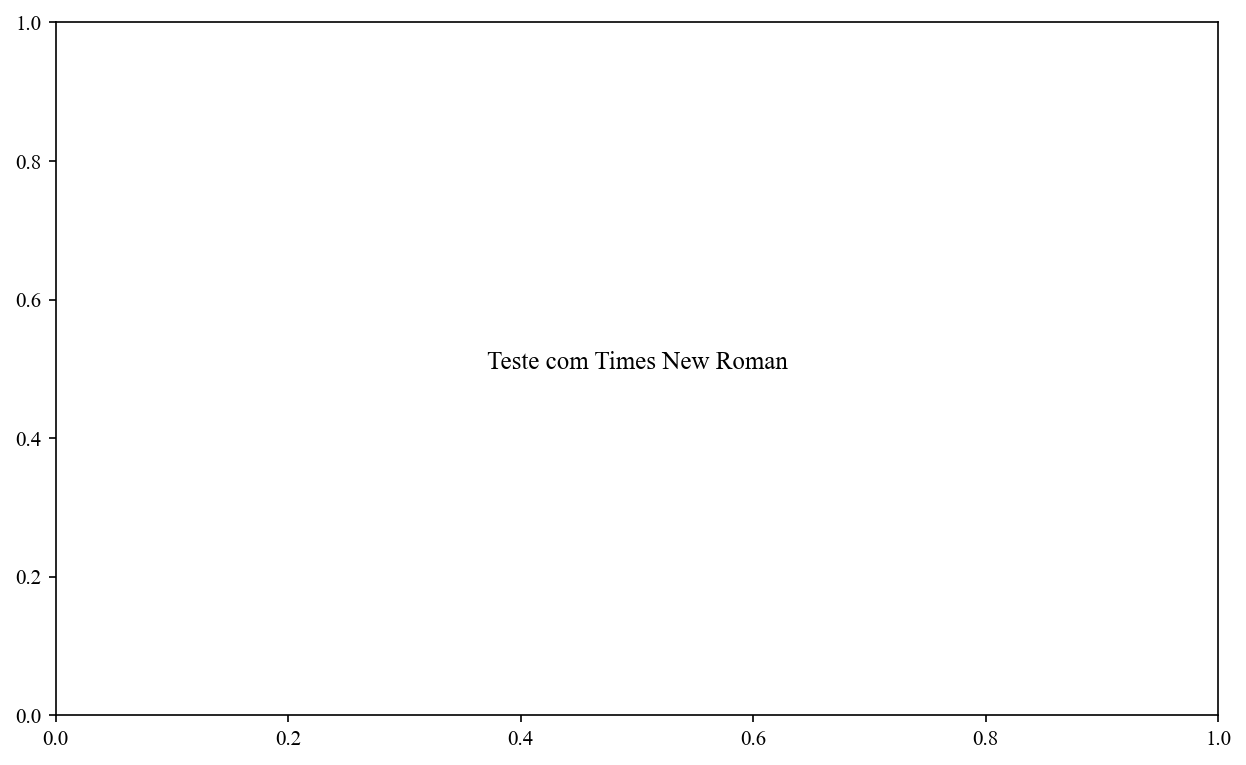

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm.findSystemFonts(fontpaths=["/usr/share/fonts/truetype/"])

plt.rcParams["font.family"] = "Times New Roman"

plt.text(0.5, 0.5, 'Teste com Times New Roman', fontsize=12, ha='center')
plt.show()


### Imports

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from skbio.diversity import alpha_diversity
from scipy.spatial.distance import pdist, squareform
from skbio.diversity import beta_diversity

### Auxiliar functions

In [3]:
def load_asv_file(file_path):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, sep='\t', index_col=0)
        if df.empty:
            raise ValueError(f"Erro: O arquivo ASV foi carregado, mas está vazio: {file_path}")

        # Transpor a tabela (inversão de linhas e colunas)
        df_transposed = df.T

        return df_transposed
    else:
        raise FileNotFoundError(f"Erro: Arquivo ASV não encontrado: {file_path}")

## Data Preparation and Wrangling

### Metadata Loading

In [4]:
meta_all = pd.read_csv('../drive/Bettle_experiments/01_metadata_productivity.txt', sep='\t', index_col = 0)

In [5]:
meta_all.info()

<class 'pandas.DataFrame'>
Index: 55 entries, UNDR03_2 to merge_NG-28520_B96
Data columns (total 14 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Gut compartiment                                  55 non-null     str    
 1   Experiment                                        55 non-null     str    
 2   Category                                          55 non-null     str    
 3   Category2                                         55 non-null     str    
 4   Specific CH4 production (mLNorm gVS-1)_corrected  40 non-null     float64
 5   CH4 (%)                                           40 non-null     float64
 6   O2 (%)                                            40 non-null     float64
 7   CO2 (%)                                           40 non-null     float64
 8   H2 (%)                                            40 non-null     str    
 9   N2 (%)          

### ASV loading

In [6]:
asv_all = load_asv_file("../drive/Bettle_experiments/01_map_complete_relative_abundance_table.tsv")
asv_all.info()

<class 'pandas.DataFrame'>
Index: 55 entries, UNDR01_2HCb to merge_NG-28520_B96
Columns: 589 entries, UNDR01_2HCb-bin.0 to merge_NG-28520_B96-bin.82
dtypes: float64(589)
memory usage: 253.5+ KB


### Merging on 'SampleID'

In [7]:
merged = pd.merge(meta_all[['Gut compartiment', 'Experiment', 'Category']], asv_all,
                  how='inner', left_index=True, right_index=True)
merged.info()

<class 'pandas.DataFrame'>
Index: 55 entries, UNDR03_2 to merge_NG-28520_B96
Columns: 592 entries, Gut compartiment to merge_NG-28520_B96-bin.82
dtypes: float64(589), str(3)
memory usage: 254.8+ KB


#### Checking ASVs with count zero in all samples

In [8]:
merged.columns[(merged==0).all()]

Index([], dtype='str')

### Updating Category in Metadata Dataset

This part of the original notebook is kind of nebulous. 
The author doesn't explain why change only the '1T' and
'Inoculum' values of the 'Category' column. 

In [9]:
def update_categoria(row):
    if row['Category'] == '1T':
      return f"1T-{row['Category2']}"
    elif row['Category'] == 'Inoculum':
        return f"Inoculum-{row['Category2']}"
    return row['Category']

In [10]:
meta_all['Category'] = meta_all.apply(update_categoria, axis=1)
meta_all['Category'].unique()

<StringArray>
[       '1T-1',          '3T',        '1T-2',          '2T',  'Inoculum-1',
  'Inoculum-2',          'R1',          'R2',          'R3', 'Inoculum-R1',
 'Inoculum-R2', 'Inoculum-R3',        'Foam']
Length: 13, dtype: str

## Visual Analysis

### Relevant imports

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from skbio.diversity import alpha_diversity
from skbio.stats.distance import permanova
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from skbio import DistanceMatrix
from scipy.stats import kruskal

In [12]:
metadata = meta_all.loc[:, ['Gut compartiment', 'Experiment', 'Category']].copy()
metadata.shape

(55, 3)

### Markers for graphs:

In [13]:
markers = {
    '1T': 'o',           # círculo
    '2T': 's',           # quadrado
    '3T': 'D',           # losango
    'R1': '^',           # triângulo
    'R2': 'P',           # pentágono
    'R3': 'X',           # cruz
    'Foam': '*',         # estrela
    'Inoculum': 'v',     # triângulo invertido

    # Novos símbolos preenchidos para as categorias específicas
    'Inoculum-1': 'p',   # pentágono
    'Inoculum-2': 'H',   # hexágono
    'Inoculum-R1': 'd',  # pequeno losango
    'Inoculum-R2': 'h',  # hexágono
    'Inoculum-R3': 'X',  # cruz
    '1T-1': 'o',         # círculo
    '1T-2': 's'          # quadrado
}

markers_exp = {
    'Enrichement': 'o',  # círculo
    'Reactor': 's',     # quadrado
}

### Bray-Curtis distance

In [14]:
dist_matrix = pdist(asv_all, metric='braycurtis')
dist_matrix_square = squareform(dist_matrix)
print(dist_matrix.shape)
print(dist_matrix_square.shape)

(1485,)
(55, 55)


### Alpha Diversity with Shannon index

#### A problem with the author's notebook?

Note that the author calculates alpha diversity using asv count values,
but metadata index. This produces different results than calculating
with asv values AND index, as shown below. I continue by calculating
with asv index, passing to a Series and then merging.

In [16]:
alpha_diversity('shannon', asv_all.values, ids=asv_all.index).head()

UNDR01_2HCb    4.188617
UNDR01_2MCb    4.026101
UNDR03_102     3.625641
UNDR03_117     3.215200
UNDR03_118     3.338179
dtype: float64

In [17]:
diversity = alpha_diversity('shannon', asv_all.values, ids=asv_all.index)
diversity.name = 'Shannon'
metadata = pd.merge(metadata, diversity, left_index=True, right_index=True, how='inner')
metadata['Shannon']

Sample
UNDR03_2              2.873040
UNDR03_3              2.999909
UNDR03_4              2.917302
UNDR03_5              3.966982
UNDR03_6              3.923636
UNDR03_7              3.763416
UNDR03_22             2.495317
UNDR03_23             2.213052
UNDR03_24             2.316901
UNDR03_25             2.517044
UNDR03_26             2.816441
UNDR03_27             2.827235
UNDR03_74             4.103870
UNDR03_75             3.800203
UNDR03_76             4.113973
UNDR03_78             4.159256
UNDR03_79             4.057861
UNDR03_80             4.143663
UNDR03_102            3.625641
UNDR03_117            3.215200
UNDR03_118            3.338179
UNDR03_119            3.199513
UNDR03_121            3.555914
UNDR03_122            3.478707
UNDR03_123            3.547131
UNDR03_1MAa           3.433469
UNDR03_1MCa           3.477774
UNDR03_1HAb           3.792215
UNDR03_1HBb           3.817707
UNDR03_2MAa           4.300278
UNDR03_2MBb           3.862924
UNDR01_2MCb           4.026101
U

### Observed OTUs

In [18]:
metadata['Observed_OTUs'] = np.sum(asv_all.values > 0, axis=1)

### Plots and T-Test by Gut Segment

#### Plotting Shannon Diversity Boxplot by Gut Segment

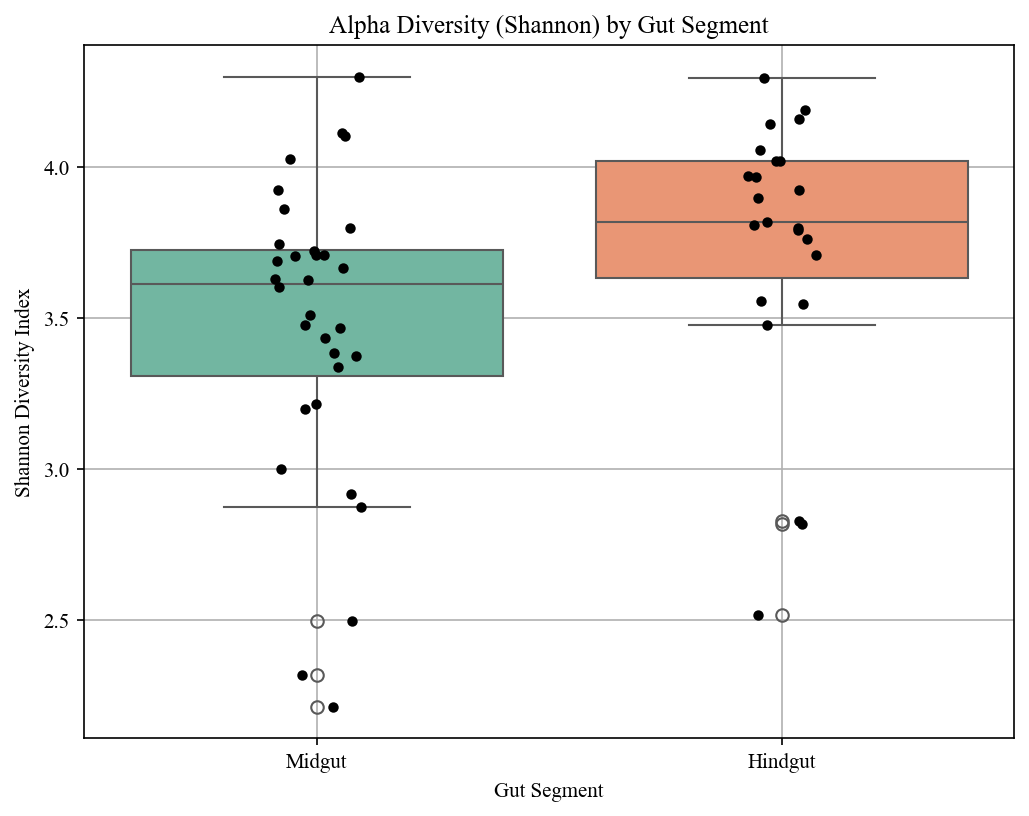

In [19]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=metadata, x='Gut compartiment', y='Shannon', 
            hue='Gut compartiment', palette='Set2')

sns.stripplot(data=metadata, x='Gut compartiment', y='Shannon',
              color='black', jitter=True)

plt.title('Alpha Diversity (Shannon) by Gut Segment')
plt.ylabel('Shannon Diversity Index')
plt.xlabel('Gut Segment')
plt.grid(True)
plt.show()

#### Plotting OTU Count Boxplot by Gut Segment

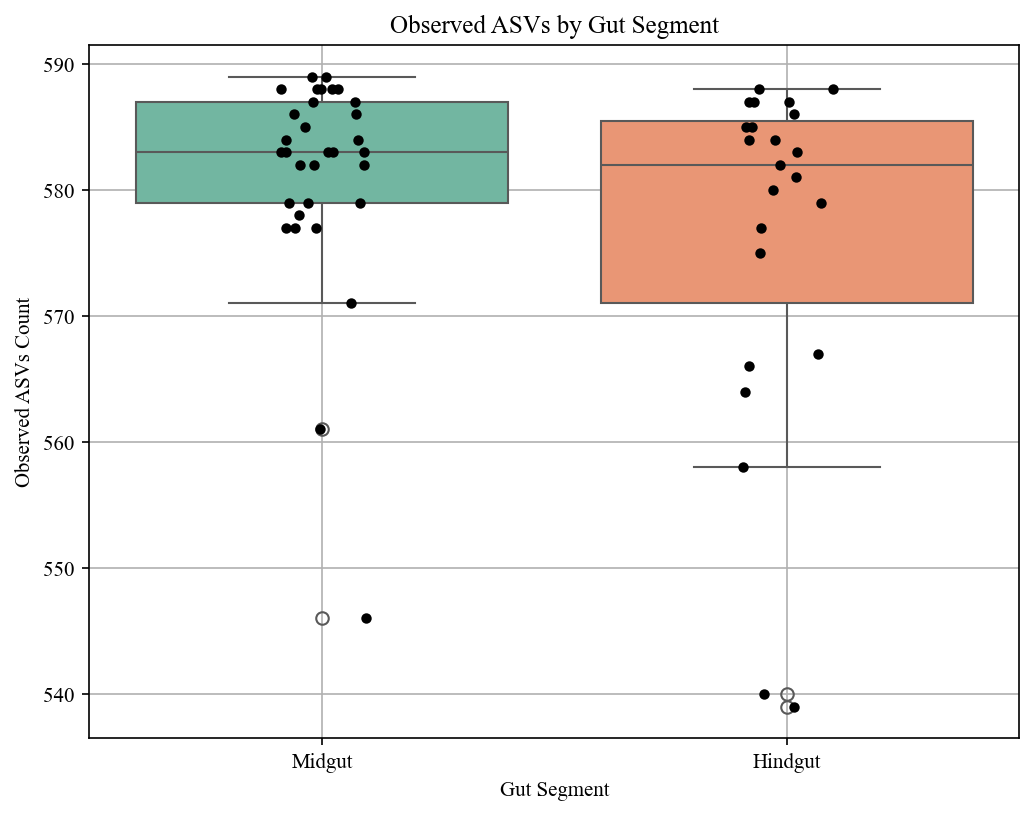

In [20]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=metadata, x='Gut compartiment', y='Observed_OTUs',
            hue='Gut compartiment', palette='Set2')
sns.stripplot(data=metadata, x='Gut compartiment', y='Observed_OTUs', color='black', jitter=True)
plt.title('Observed ASVs by Gut Segment')
plt.ylabel('Observed ASVs Count')
plt.xlabel('Gut Segment')
plt.grid(True)
plt.show()

#### T-Test by Gut Compartiment

In [ ]:
mid_group = metadata[metadata['Gut compartiment'] == 'Midgut']
hind_group = metadata[metadata['Gut compartiment'] == 'Hindgut']

t_shannon, p_shannon = ttest_ind(mid_group['Shannon'], hind_group['Shannon'])

t_asv, p_asv = ttest_ind(mid_group['Observed_OTUs'], hind_group['Observed_OTUs'])

dist_matrix_obj = DistanceMatrix(dist_matrix_square, ids=asv_all.index)
print(f"Teste t para Shannon: t={t_shannon:.4f}, p={p_shannon:.4f}")
print(f"Teste t para ASVs observados: t={t_asv:.4f}, p={p_asv:.4f}")

#### PERMANOVA

In [51]:
permanova_results = permanova(dist_matrix_obj, metadata['Gut compartiment'], permutations=999)
print(f"PERMANOVA results: pseudo-F={permanova_results['test statistic']:.4f}, p-value={permanova_results['p-value']:.4f}")

PERMANOVA results: pseudo-F=1.5141, p-value=0.1650


### T-Test and Plots by Experiment

I suspect this could be problematic because, as the code comments
suggest, the author intended to do a T-Test of Shannon index and
Observed ASVs between HRT of 8 days and 2 days. The thing is, she
assigns to `group_8d` the metadata columns with 'Experiment' == 'Enrichment'
and `group_2d` with 'Experiment' == 'Reactor'. The enrichment experiment
metadata table has no info on HRT both in it's metadata file and in
the experiment's article. This is, then, a T-Test between experiments,
not HRTs.

#### T-Testing

In [46]:
enrich_group = metadata[metadata['Experiment'] == 'Enrichement']
reactor_group = metadata[metadata['Experiment'] == 'Reactor']

t_shannon, p_shannon = ttest_ind(enrich_group['Shannon'], reactor_group['Shannon'])

t_asv, p_asv = ttest_ind(enrich_group['Observed_OTUs'], reactor_group['Observed_OTUs'])


print(f"Teste t para Shannon: t={t_shannon:.4f}, p={p_shannon:.4f}")
print(f"Teste t para ASVs observados: t={t_asv:.4f}, p={p_asv:.4f}")

Teste t para Shannon: t=-1.5672, p=0.1230
Teste t para ASVs observados: t=-2.5666, p=0.0131


#### Plotting Shannon and OTU Count By Experiment

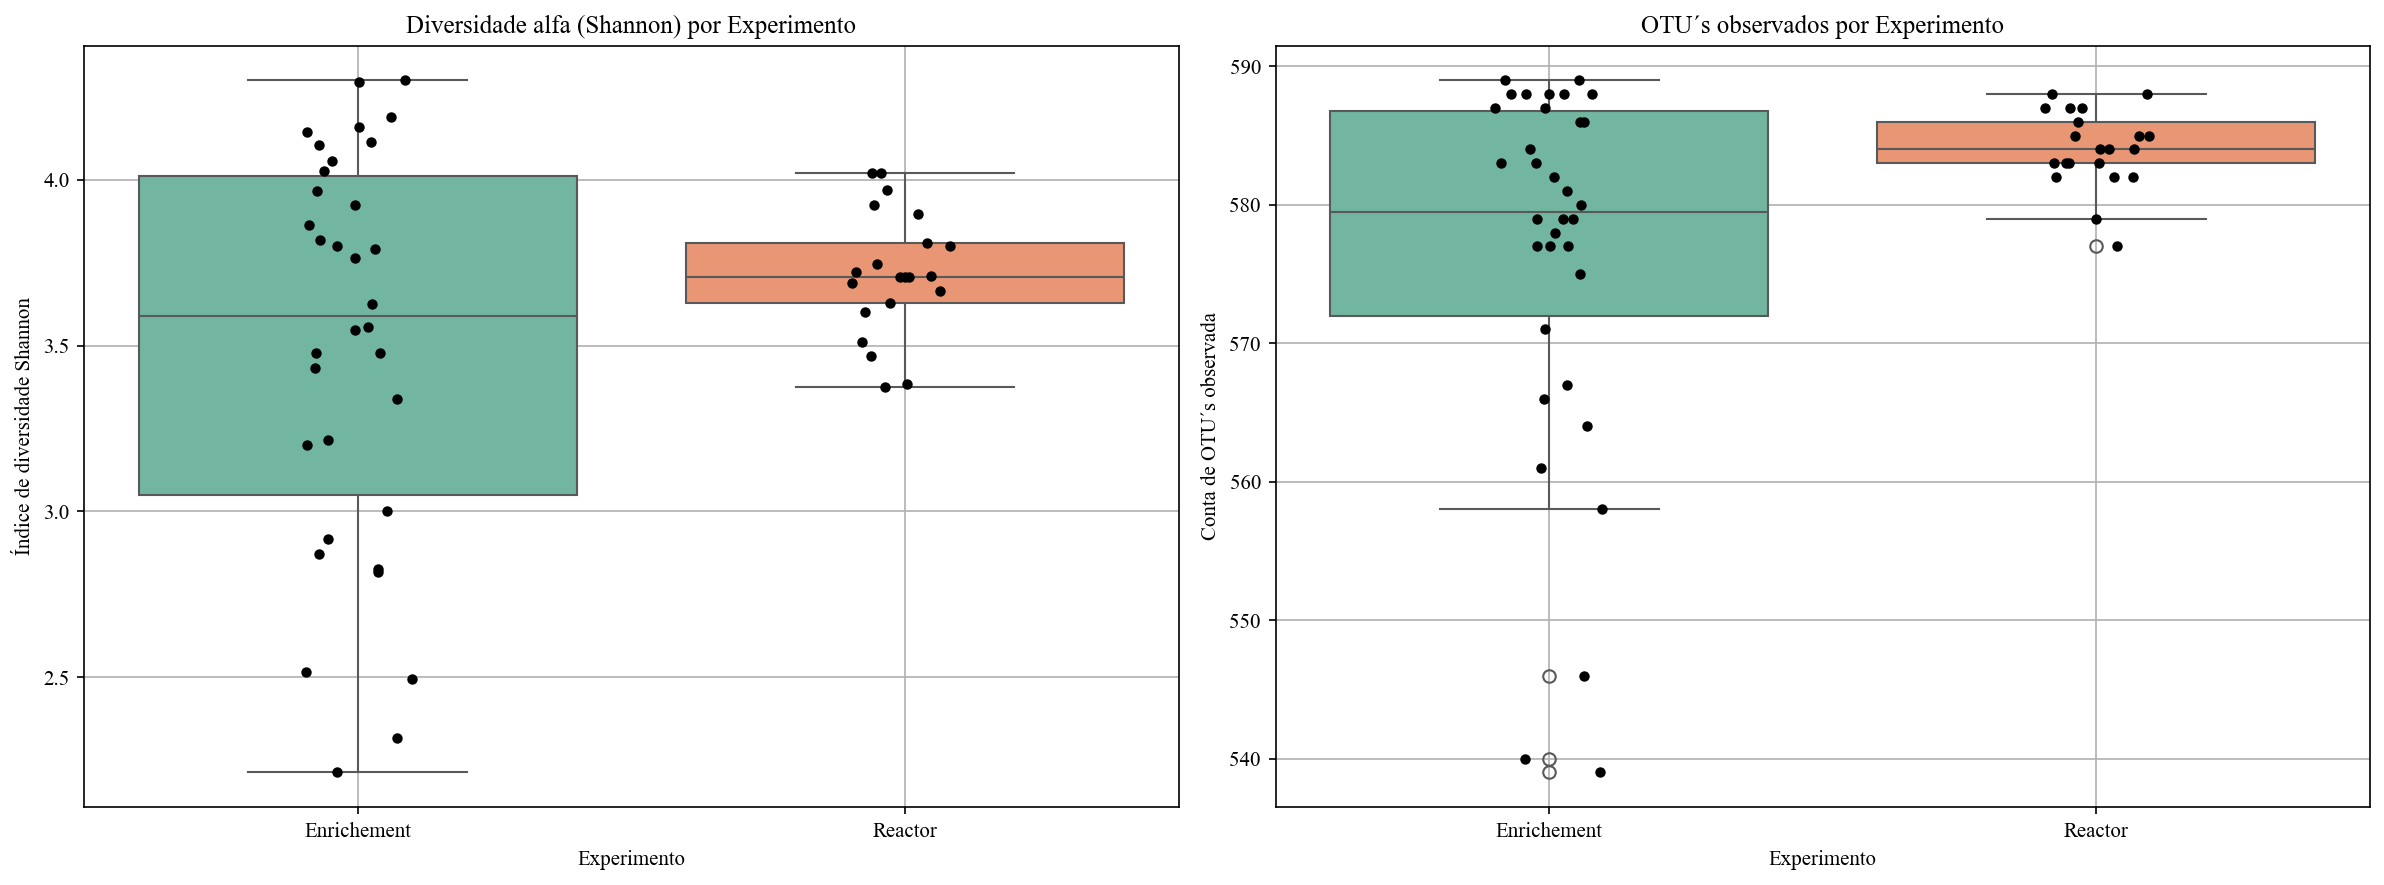

In [47]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 6))

# Plotando o boxplot da diversidade de Shannon por Experiment
sns.boxplot(data=metadata, x='Experiment', y='Shannon', 
            hue='Experiment', palette='Set2', ax=ax3)

sns.stripplot(data=metadata, x='Experiment', y='Shannon', 
              color='black', jitter=True, ax=ax3)

ax3.set_title('Diversidade alfa (Shannon) por Experimento')
ax3.set_ylabel('Índice de diversidade Shannon')
ax3.set_xlabel('Experimento')
ax3.grid(True)

# Plotando o boxplot da contagem de ASVs observados
sns.boxplot(data=metadata, x='Experiment', y='Observed_OTUs', 
            hue='Experiment', palette='Set2', ax=ax4)

sns.stripplot(data=metadata, x='Experiment', y='Observed_OTUs', 
              color='black', jitter=True, ax=ax4)

ax4.set_title('OTU´s observados por Experimento')
ax4.set_ylabel('Conta de OTU´s observada')
ax4.set_xlabel('Experimento')
ax4.grid(True)

# Ajustar o espaçamento entre os gráficos
plt.tight_layout()
plt.show()

### NDMS Analysis


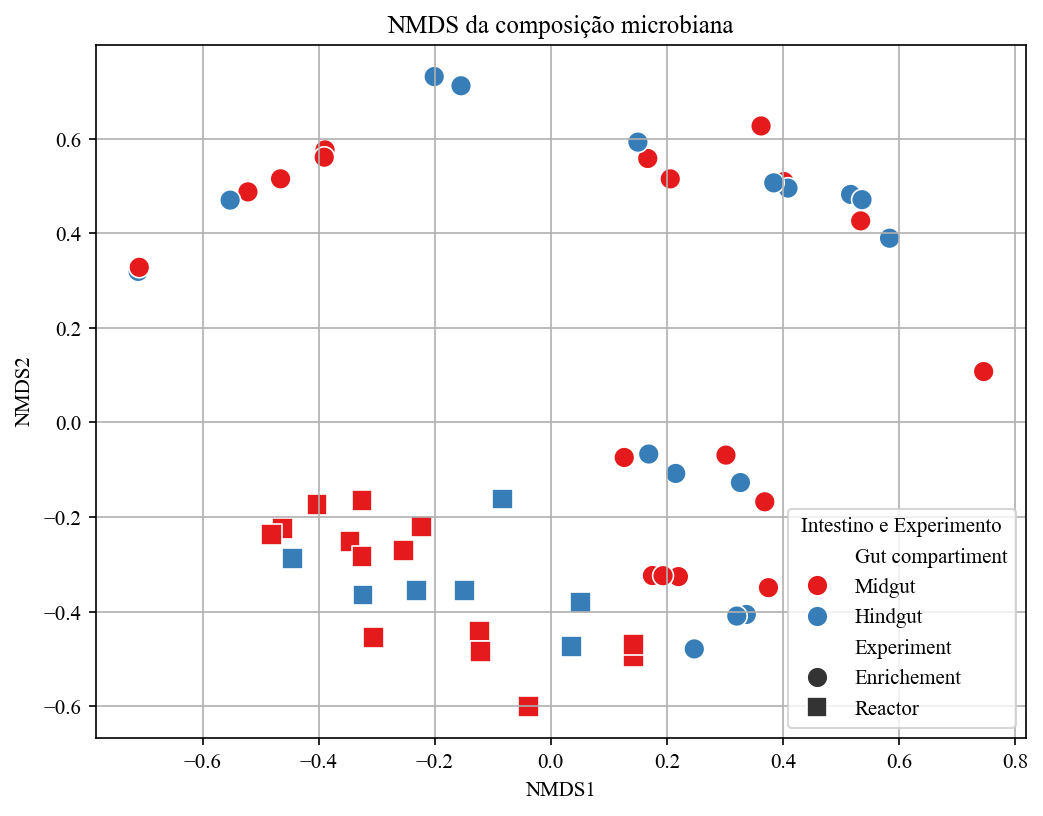

In [24]:
mds = MDS(n_components=2, metric='precomputed', random_state=42,
          n_init=4, init='random')
nmds_results = mds.fit_transform(dist_matrix_square)

metadata['NMDS1'] = nmds_results[:, 0]
metadata['NMDS2'] = nmds_results[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=metadata, x='NMDS1', y='NMDS2', hue='Gut compartiment', style='Experiment',
                palette='Set1', s=100, markers=markers_exp)
plt.title('NMDS da composição microbiana')
plt.xlabel('NMDS1')
plt.ylabel('NMDS2')
plt.legend(title='Intestino e Experimento')
plt.grid(True)
plt.show()

### PERMANOVA for Beta Diversity

In [25]:
dist_matrix_obj = DistanceMatrix(dist_matrix_square, ids=asv_all.index)
permanova_results = permanova(dist_matrix_obj, metadata['Experiment'], permutations=999)
print(f"PERMANOVA results: pseudo-F={permanova_results['test statistic']:.4f}, p-value={permanova_results['p-value']:.4f}")

PERMANOVA results: pseudo-F=14.0135, p-value=0.0010


### Kruskal-Wallis Test

In [26]:
# Agrupar dados por diferentes classes no campo "Experiment"
# Lista para armazenar os valores de Shannon e Observed_ASV para cada classe
shannon_groups = []
asv_groups = []

# Adiciona os dados de cada grupo em listas para o teste Kruskal-Wallis
for group in metadata['Experiment'].unique():
    shannon_groups.append(metadata[metadata['Experiment'] == group]['Shannon'])
    asv_groups.append(metadata[metadata['Experiment'] == group]['Observed_OTUs'])

# Teste de Kruskal-Wallis para Shannon
h_shannon, p_shannon = kruskal(*shannon_groups)

# Teste de Kruskal-Wallis para ASV observados
h_asv, p_asv = kruskal(*asv_groups)

print(f"Teste Kruskal-Wallis para Shannon: H={h_shannon:.4f}, p={p_shannon:.4f}")
print(f"Teste Kruskal-Wallis para ASVs observados: H={h_asv:.4f}, p={p_asv:.4f}")

Teste Kruskal-Wallis para Shannon: H=0.4334, p=0.5103
Teste Kruskal-Wallis para ASVs observados: H=3.6525, p=0.0560


### Plotting Observed OTUs and Shannon Diversity per Experiment Category

First, set plot to two side-by-side plots:

/tmp/ipykernel_23196/3153598654.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


/tmp/ipykernel_23196/3153598654.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


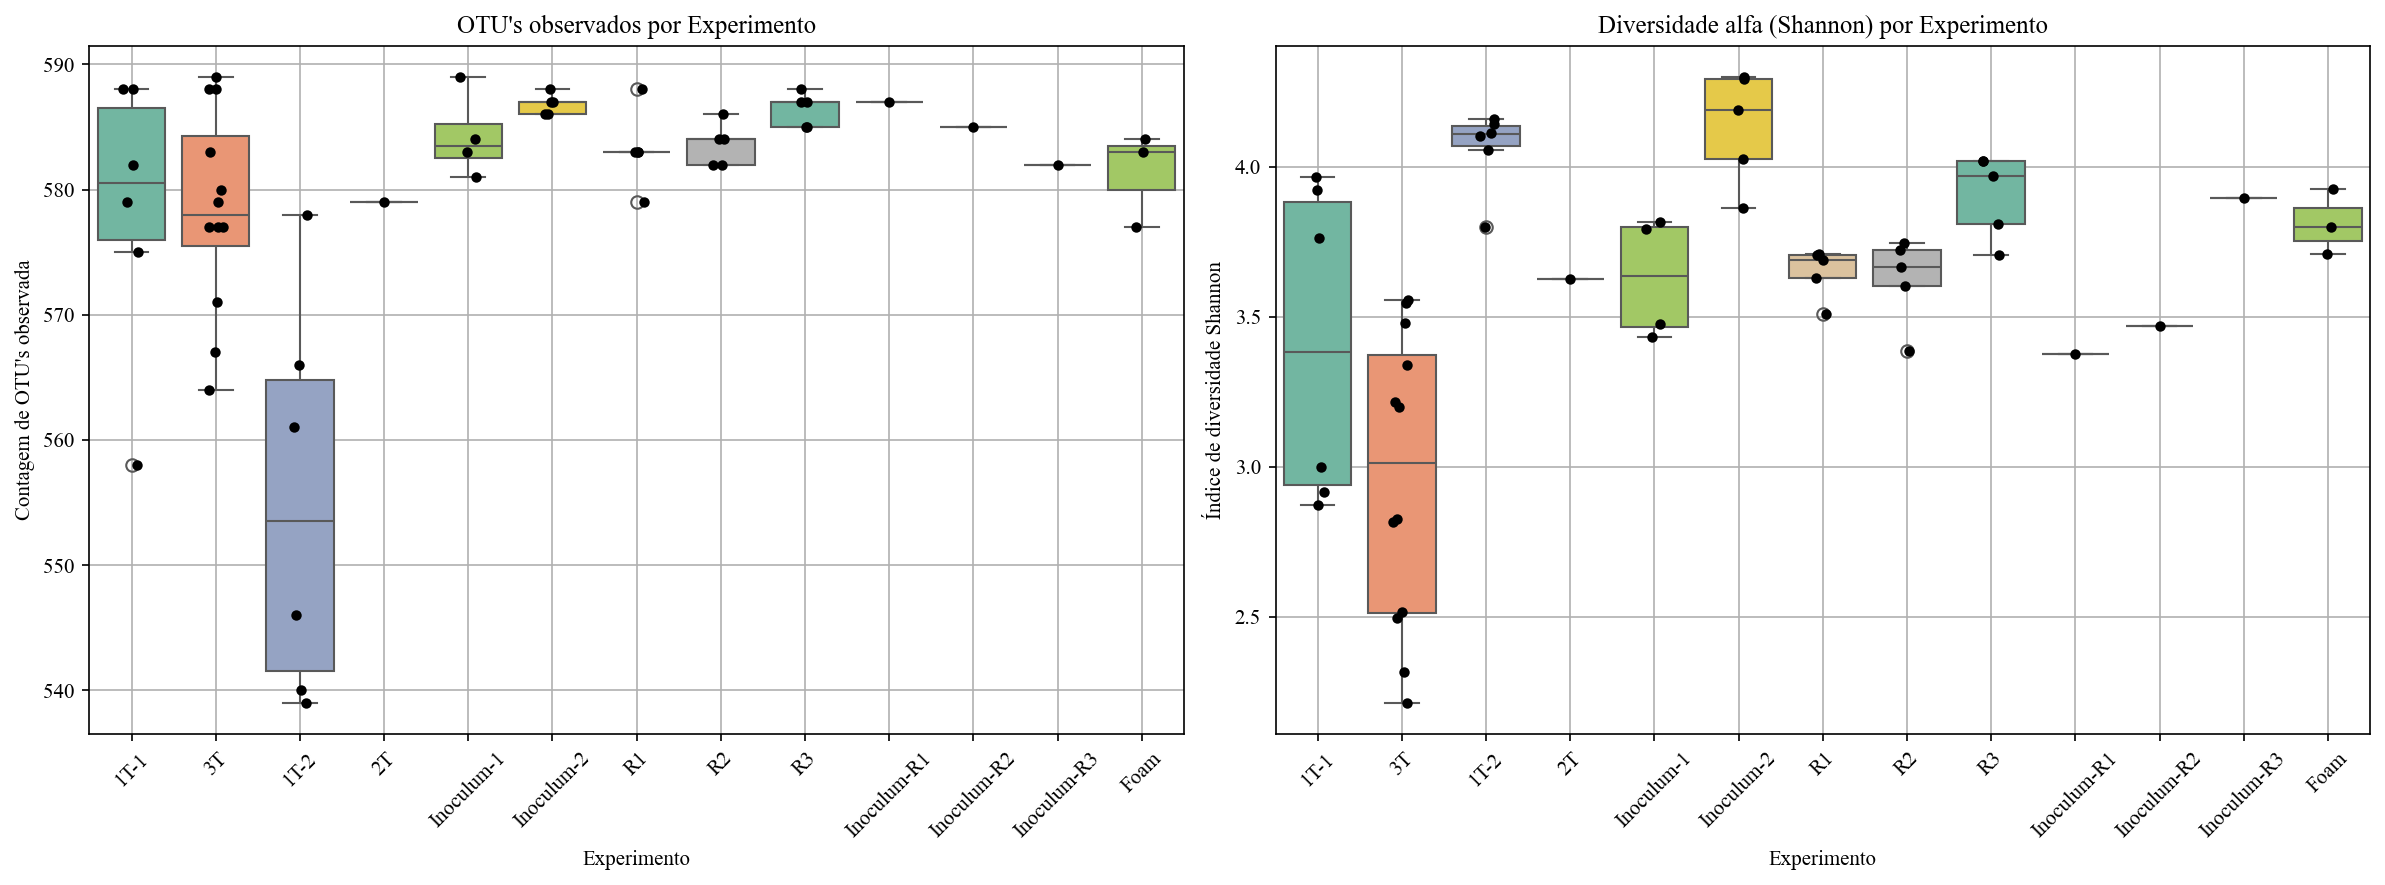

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Observed OTUs by Category

sns.boxplot(data=metadata, x='Category', y='Observed_OTUs', 
            hue='Category', palette='Set2', ax=ax1)
sns.stripplot(data=metadata, x='Category', y='Observed_OTUs', 
              color='black', jitter=True, ax=ax1)
ax1.set_title("OTU's observados por Experimento")
ax1.set_ylabel("Contagem de OTU's observada")
ax1.set_xlabel("Experimento")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.grid(True)

# Shannon Diversity by Category

sns.boxplot(data=metadata, x='Category', y='Shannon', 
            hue='Category', palette='Set2', ax=ax2)
sns.stripplot(data=metadata, x='Category', y='Shannon', 
              color='black', jitter=True, ax=ax2)
ax2.set_title("Diversidade alfa (Shannon) por Experimento")
ax2.set_ylabel("Índice de diversidade Shannon")
ax2.set_xlabel("Experimento")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.grid(True)

plt.tight_layout()
plt.show()

### Plotting NDMS by Gut Compartiment and Category

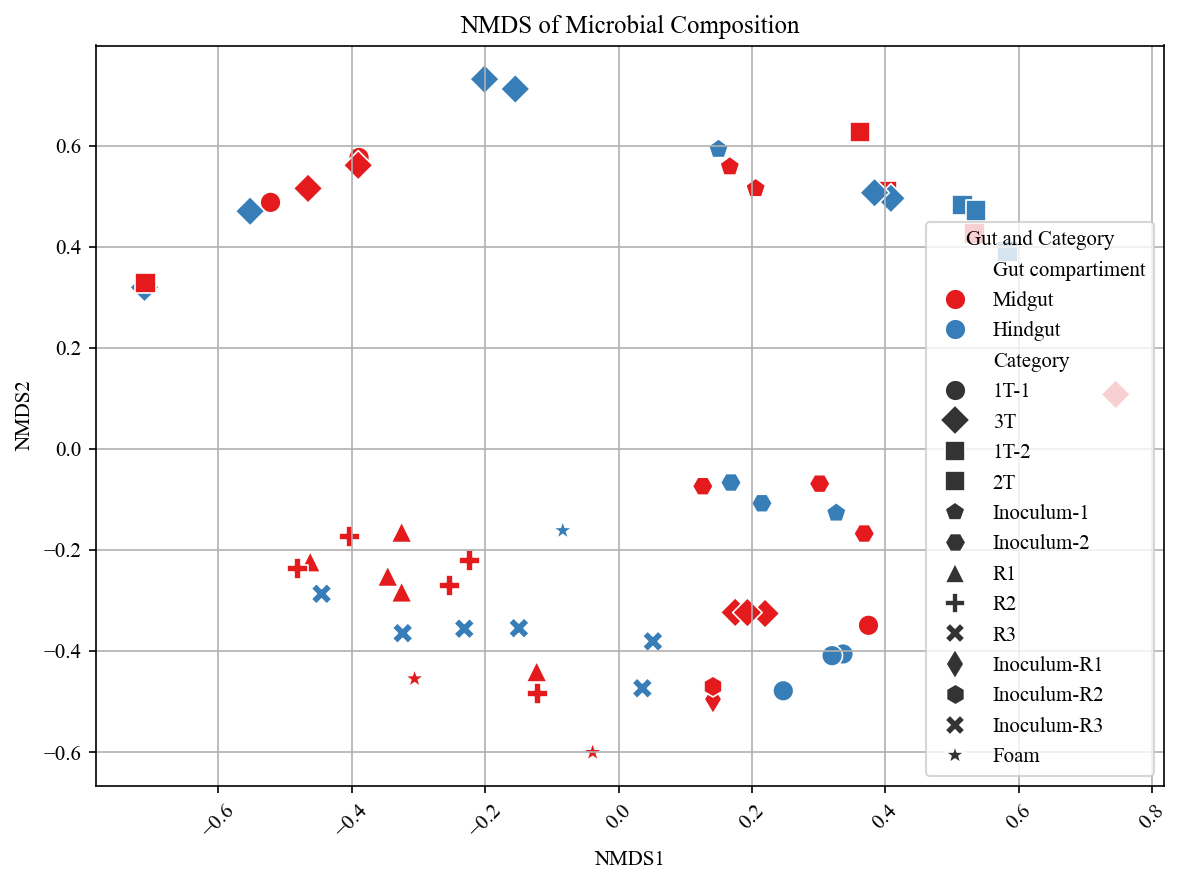

PERMANOVA results: pseudo-F=1.5141, p-value=0.1380


In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=metadata, x='NMDS1', y='NMDS2', hue='Gut compartiment', style='Category',
                palette='Set1', s=100, markers=markers)
plt.title('NMDS of Microbial Composition')
plt.xlabel('NMDS1')
plt.ylabel('NMDS2')
plt.legend(title='Gut and Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)

#mostrar grafico
plt.show()

# Criar um objeto DistanceMatrix com os IDs das amostras
dist_matrix_obj = DistanceMatrix(dist_matrix_square, ids=asv_all.index)
permanova_results = permanova(dist_matrix_obj, metadata['Gut compartiment'], permutations=999)
print(f"PERMANOVA results: pseudo-F={permanova_results['test statistic']:.4f}, p-value={permanova_results['p-value']:.4f}")